In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import datetime
import numpy as np
import scipy.stats as sps

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import world_bank_data as wb

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

# What countries have experienced a similar COVID-19 outbreak as Denmark and is it possible to identify any patterns relating to this using the economic and societal variables provided in the Cities dataset?

## IMPORTING DATASETS

In this notebook we will be pulling data from ourworldindata.org which is updated daily, based on data from John Hopkins University. This report is finalized on December 5th and all analysis will is based the data available at that date. However this notebook is 'live' as it pulls the newest data available so results may change in the future. 
Covid data: https://ourworldindata.org/coronavirus-source-data

In [2]:
data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

Our dataset contains numerous time series for every country. The problem is that each country spans hundreds of rows corresponding to the date the data was sampled at, so we will have to parse all the rows and organize them by country.

The dataset for some countries goes back to January 1st 2020 but since COVID-19 was a new phenomenon and the virus did not become a global health emergency until some months later, we will only be looking at data from the 1st of March and onward. The data we are using is updated daily but we will be discarding the data that is less than a week old because it is subject to change and may affect our analysis.

In [3]:
from datetime import date,timedelta

data['date']=pd.to_datetime(data['date']) #set it to datetime
cutoff = pd.to_datetime('2020-03-01')
data = data[data['date']>=cutoff]
end = date.today() - timedelta(days=7)
end = pd.to_datetime(end)
data = data[data['date']<=end]

So how many countries do we have in the dataset?

In [4]:
countries_list = data['location'].unique()
print('Number of countries:',len(countries_list))

Number of countries: 192


Now we will try to extract a single time series, corresponding to the number of new cases each day in Denmark. We will work with the number of new cases per million because otherwise it is hard to compare countries with big differences in population.

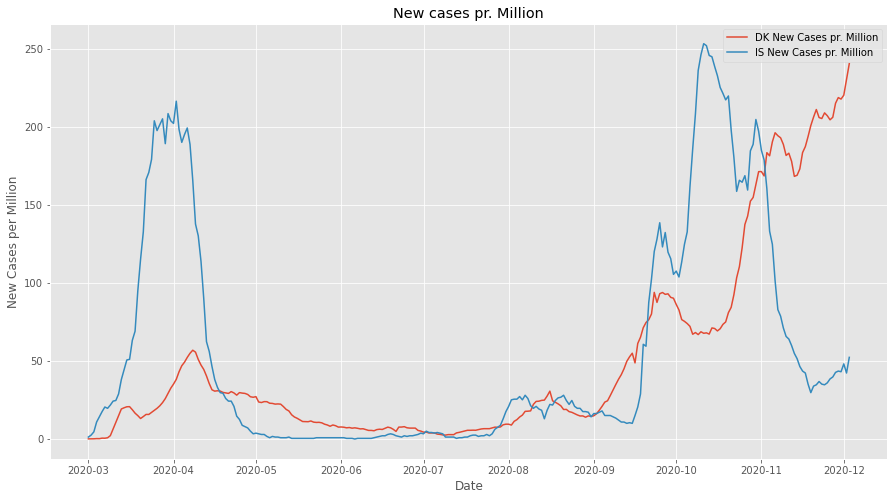

In [36]:
dk = data.loc[data['location']=="Denmark"]['new_cases_smoothed_per_million'].values
isk = data.loc[data['location']=="Iceland"]['new_cases_smoothed_per_million'].values

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(data.loc[data['location']=="Denmark"]['date'],dk,label = 'DK New Cases pr. Million')
ax.plot(data.loc[data['location']=="Iceland"]['date'],isk,label = 'IS New Cases pr. Million')
ax.set_xlabel('Date')
ax.set_ylabel('New Cases per Million')  # Add a y-label to the axes.
ax.set_title("New cases pr. Million")  # Add a title to the axes.
ax.legend()  # Add a legend.

That looks quite messy, it appears that cases are going from zero to over 200 in the span of a few days. However, from the news coverage on the pandemic we know that a more appropriate indicator of rate of infection is a weekly average, since some countries don't report cases during the weekend and that it can take anywhere from a few days to a couple of weeks for symptoms to develop after an infection. Luckily there is a column in our data called *new_cases_smoothed* that contains the same data, only smoothed over a period of a week that provides a clearer picture of the general trend of confirmed cases.

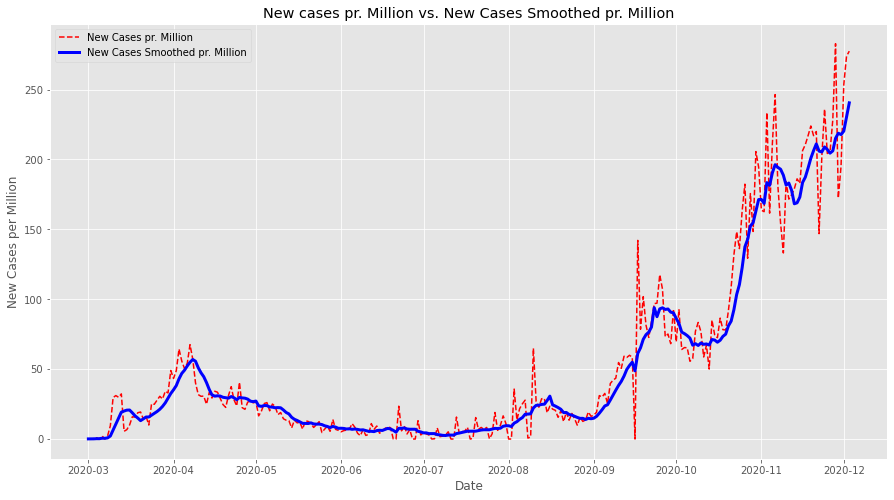

In [6]:
dk_smoothed = data.loc[data['location']=="Denmark"]['new_cases_smoothed_per_million'].values
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(data.loc[data['location']=="Denmark"]['date'],dk,'r--',label = 'New Cases pr. Million')
ax.plot(data.loc[data['location']=="Denmark"]['date'],dk_smoothed,linewidth=3,c='blue',label = 'New Cases Smoothed pr. Million')
ax.set_xlabel('Date')
ax.set_ylabel('New Cases per Million')  # Add a y-label to the axes.
ax.set_title("New cases pr. Million vs. New Cases Smoothed pr. Million")  # Add a title to the axes.
ax.legend()  # Add a legend.

It looks much clearer now. Moving forward, we will use the smoothed data per million.

Are all the time series in the data as complete as Denmark's? Countries have responded to the virus in very different ways, so let's see where we have complete data.

In [7]:
n_points = []
for i in data['location'].unique():
    n = len(data.loc[data['location']==i]['new_cases_smoothed_per_million'].values)
    n_points.append(n)
print("Denmark has", len(dk_smoothed),"data points")
print("Maximum number of data points:" ,max(n_points))

Denmark has 278 data points
Maximum number of data points: 278


In [8]:
complete = []

max_n = max(n_points)

data.loc[data['location']==i]['new_cases_smoothed_per_million']

for i in data['location'].unique():
    n = len(data.loc[data['location']==i]['new_cases_smoothed_per_million'].values)
    if n == max_n:
        complete.append(i)
    else:
           continue
print(len(complete), "complete data sets")

191 complete data sets


So we have complete data sets, two of these are 'World' and 'International' which we will not be using. After plotting all the time series together (see below), we also decided to discard the Vatican time series because of irregularities.

In [9]:
throw_away = ['World','International','Vatican']

for i in complete:
    if i in throw_away:
        complete.remove(i)
    else: continue

Now we read all of the time series that we want to examine into a dictionary and convert it into a pandas dataframe

In [10]:
dicts = {}

keys = list(complete)
for i in keys:
        dicts[i] = data.loc[data['location']==i]['new_cases_smoothed_per_million'].values
        
ts_data = pd.DataFrame(dicts)
ts_data

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,0.004,0.000,0.003,0.000,0.000,0.000,0.000,0.048,0.067,0.222,...,0.139,0.007,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.010,1.849,0.000,0.000,0.000,0.048,0.084,0.286,...,0.219,0.017,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
2,0.004,0.000,0.013,1.849,0.000,0.000,0.003,0.048,0.134,0.301,...,0.326,0.025,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
3,0.011,0.000,0.036,1.849,0.000,0.000,0.003,0.048,0.207,0.428,...,0.440,0.039,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
4,0.011,0.000,0.036,1.849,0.000,0.000,0.003,0.048,0.224,0.603,...,0.528,0.072,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,5.174,241.454,23.974,843.110,2.651,2.918,153.115,411.905,0.381,515.824,...,222.017,490.489,41.824,5.348,0.0,11.078,0.053,0.374,1.430,5.786
274,4.719,229.640,23.886,815.376,2.195,2.918,157.733,405.686,0.387,509.527,...,215.626,484.591,44.991,5.634,0.0,11.309,0.051,0.402,1.500,6.171
275,4.925,234.008,23.300,811.678,2.212,4.376,160.492,407.132,0.392,488.208,...,220.157,487.893,47.458,5.510,0.0,10.666,0.051,0.398,1.546,7.026
276,4.895,237.036,22.997,765.455,2.165,5.835,157.142,392.718,0.415,459.181,...,215.898,496.015,50.872,4.729,0.0,11.304,0.054,0.445,1.282,5.969


In [11]:
period = list(data.loc[data['location']=="Denmark"]['date'].values) #we just need to get the timeframe
                                                                         #from one of the countries in our dataframe
ts_data['datetime']= period #add it to the dataframe
ts_data['datetime']=pd.to_datetime(ts_data['datetime']) #set it to datetime
ts_data.set_index('datetime',inplace=True) #set it as the index

Let's try to plot them

Text(0.5, 1.0, 'New Cases Smoothed pr. Million Worldwide')

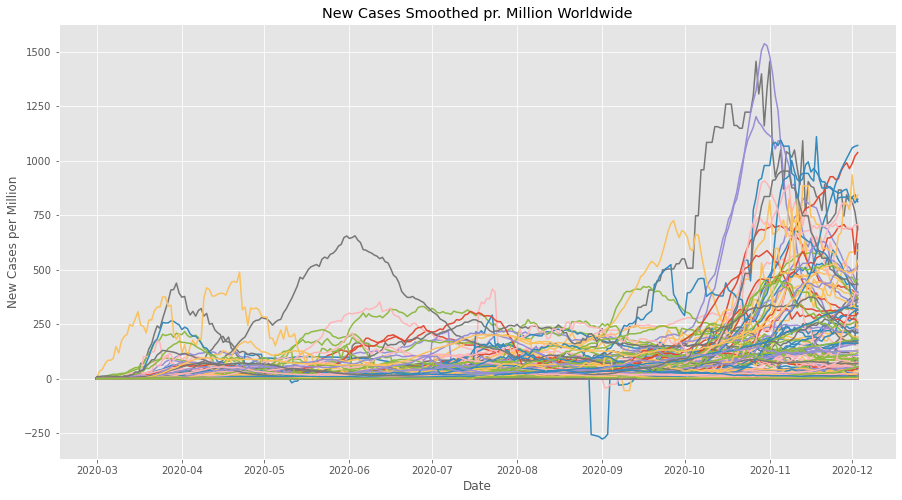

In [12]:
plt.close()

fig, ax = plt.subplots()  # Create a figure and an axes.
for i in ts_data:
    plt.plot(period,ts_data[i])

ax.set_xlabel('Date')
ax.set_ylabel('New Cases per Million')  # Add a y-label to the axes.
ax.set_title("New Cases Smoothed pr. Million Worldwide")  # Add a title to the axes.

The most surprising thing in the plot above is that we have values below zero. The reason why this happens is because countries regularly issue corrections (source:https://github.com/owid/covid-19-data/blob/master/public/data/README.md) because they have previously either overstated or underreported the number of cases, and in some cases these corrections are large enough to offset the number of new cases which results in the daily number becoming negative. Let's see which countries have negative numbers.

In [13]:
neg_val = []
for i in ts_data:
    if ts_data[i].min()<0:
        neg_val.append(i)
#print(neg_val)

for i in neg_val:
    print(i)
    print("Negative values:", ts_data[ts_data[i]<0][i].values)

Antigua and Barbuda
Negative values: [-1.459]
Benin
Negative values: [-2.321 -2.321 -2.404 -2.404 -2.404 -1.744 -1.744]
Ecuador
Negative values: [-19.206 -11.838 -11.295 -29.757 -28.761 -26.647 -25.538 -19.781 -12.907]
Guyana
Negative values: [-0.363 -0.363 -0.363 -0.363 -1.998 -2.179]
Jordan
Negative values: [-1.19  -1.134 -1.05  -0.882 -0.84  -0.7   -0.658]
Lithuania
Negative values: [-0.315 -0.682 -0.577 -1.05  -1.469 -1.574]
Luxembourg
Negative values: [-256.514 -259.481 -262.447 -266.783 -276.825 -269.978 -254.916]
Marshall Islands
Negative values: [-2.413 -2.413 -2.413 -2.413 -2.413 -2.413 -2.413]
Mauritius
Negative values: [-0.225 -0.225]
Monaco
Negative values: [-43.683 -40.043 -25.482 -25.482 -25.482  -3.64 ]
San Marino
Negative values: [-54.722 -54.722 -54.722]
Uganda
Negative values: [-0.087 -0.091 -0.091 -0.081 -0.022]
Zimbabwe
Negative values: [-0.058 -0.058]


In all likelihood, this will negatively affect our analysis. All of the countries listed above only have a handful of negative values so one way to deal with this is to dimensionally reduce the series because such few datapoints per country will not affect the overall trends of the time series and therefore will not be present in the dimensionally reduced time series.

In [14]:
from sklearn import decomposition
pca=decomposition.PCA()

In [15]:
ts_dataT = ts_data.transpose()
pca.fit(ts_dataT)

PCA()

Let's take a look at how many components we need in order to ensure that we retain maximal amount of the total variance in the data while using only a few components.

Explained Variance Ratio:

[0.698013635551438, 0.8119586552618111, 0.8918495152972667, 0.9323978450159783, 0.9509799138625528, 0.962507550371732, 0.9725605773817189, 0.9799558489809689, 0.984260316054228, 0.9873119869528362]


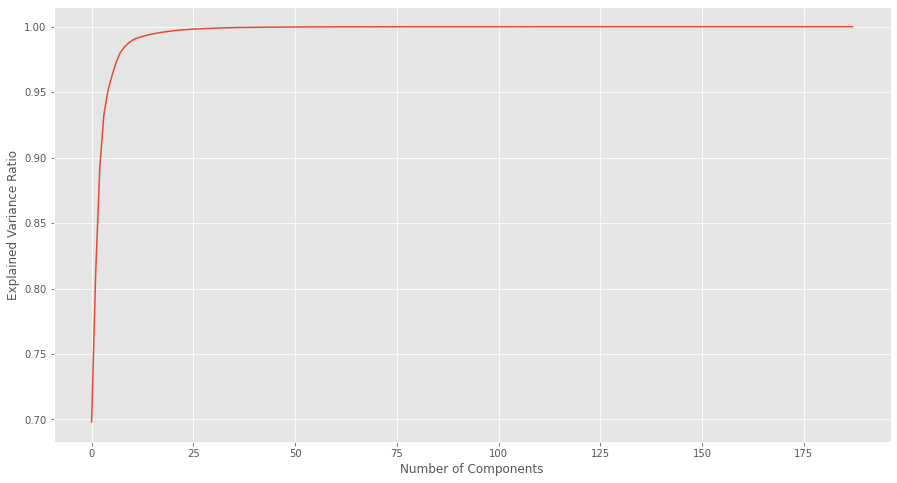

In [16]:
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]

fig, ax = plt.subplots()  # Create a figure and an axes.
plt.plot(range(len(expl)), cdf)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance Ratio')

print("Explained Variance Ratio:\n")
print(cdf[:10])

We can see that over 97% of the total variance is contained within the first 7 components. So we have reduced the time series down to only 7 dimensions

In [17]:
c = 7
pca2 = decomposition.PCA(c)
pca2.fit(ts_dataT)
ts_reduced=pca2.transform(ts_dataT)
ts_reduced.shape

(188, 7)

In [18]:
df_reduced= pd.DataFrame(ts_reduced)
df_reduced['Country Name'] = ts_dataT.index
df_reduced = df_reduced.set_index('Country Name')
df_reduced.head()

,0,1,2,3,4,5,6
Country Name,,,,,,,
Afghanistan,-912.913303,-140.352084,123.450142,67.771625,36.424287,-28.291592,44.386691
Albania,246.036080,-171.470182,-256.811186,-180.545737,-19.677536,-107.743037,-65.676363
Algeria,-832.881628,-154.350608,92.774908,-7.914054,-4.023805,0.206974,-4.883414
Andorra,6918.644159,1945.131266,1695.639556,-788.575992,1457.396896,-426.820451,-160.661837
Angola,-900.213751,-172.013136,186.574618,-3.839154,14.870548,-9.593894,26.777261


## Nearest neighbors

Now we will identify which time series are most similar to Denmark's using the nearest neighbors algorithm.

In [19]:
df_reduced.index.get_loc('Denmark')

46

In [20]:
from sklearn.neighbors import NearestNeighbors

nn = 11

nbrs = NearestNeighbors(n_neighbors=nn).fit(ts_reduced)
distances, indices = nbrs.kneighbors([ts_reduced[46,:]])
distances, indices

(array([[  0.        , 287.57750459, 338.14783073, 358.86128746,
         391.49896841, 399.71039141, 461.01648014, 490.8926152 ,
         498.71163496, 509.39644881, 518.828767  ]]),
 array([[ 46,  64,  17,   1,  66,  43,  92,  78, 114, 176,  30]],
       dtype=int64))

In [21]:
dk_nn = []

for ii in range(nn):
    dk_nn.append(df_reduced.index[indices[0,ii]])
print("Denmark and its 10 Nearest Neighbors:\n",dk_nn)

Denmark and its 10 Nearest Neighbors:
 ['Denmark', 'Germany', 'Belize', 'Albania', 'Greece', 'Cyprus', 'Latvia', 'Iran', 'Morocco', 'Ukraine', 'Canada']


This list is a bit surprising. With the exception of Germany, none of these countries seem to be particularly similar to Denmark on the surface.
Let's plot the time series of these countries to see how similar their Covid-19 situation has been.

Text(0.5, 1.0, "Denmark's Nearest Neighbors")

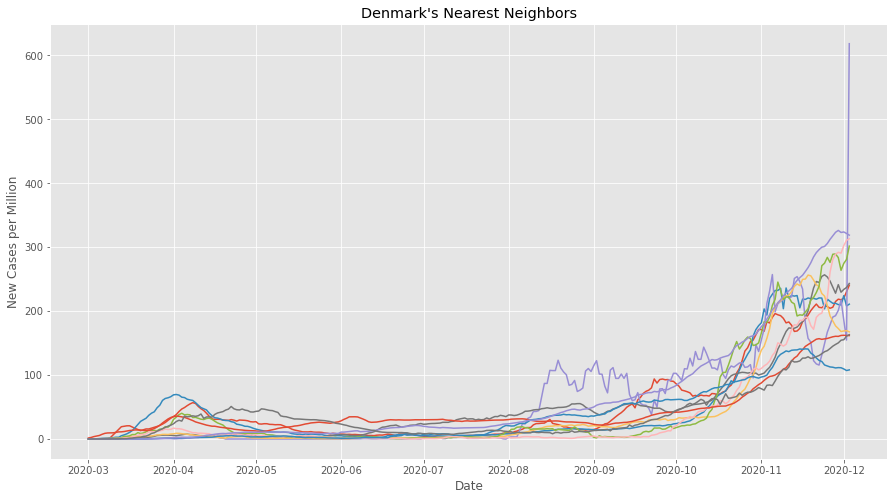

In [22]:
fig, ax = plt.subplots()  # Create a figure and an axes.
for i in dk_nn:
    plt.plot(period,ts_data[i])

ax.set_xlabel('Date')
ax.set_ylabel('New Cases per Million')  # Add a y-label to the axes.
ax.set_title("Denmark's Nearest Neighbors")  # Add a title to the axes.

We can clearly see that the time series of new cases smoothed per million for the 11 countries appear similar. The countries experienced a small first wave, followed by a long period of fewer transmissions in the spring and early summer months until cases begin to increase dramatically towards the end of the summer and in the autumn. We can spot some differences but these are relatively minor considering that the scale of this plot is much smaller than in the plot of all of the time series above.

Now that we have found countries that have experienced a similar coronavirus trend we will take a look at the *Cities* dataset from part 1 and see how cities in the countries that are similar to Denmark compare to Copenhagen. For the purposes of this project we will make the assumption that the countrywide time series can be applied to the capital cities of each country. This is a simplification but we postulate that capitals are more representative of their countries than their smaller cities.

In [23]:
df_cities = pd.read_excel('Cities.xlsx', index_col=0)
#df_cities= df_cities.set_index('City')

dfAVG = df_cities.groupby("Typology").transform(lambda x: x.fillna(x.mean()))
dfAVG.insert(4, "Continents", df_cities["Continents"], True)

dfAVG = df_cities.groupby("Continents").transform(lambda x: x.fillna(x.mean()))

dfAVG.insert(1, "City", df_cities["City"], True)
dfAVG.insert(4, "Country Name", df_cities["Country"], True)
dfAVG.insert(2, "Typology", df_cities["Typology"], True)
dfAVG.insert(3, "Continents", df_cities["Continents"], True)

dfAVG = dfAVG.set_index('Country Name')

In [24]:
from countryinfo import CountryInfo

dk_new = []
for i in dk_nn:
    if i in dfAVG.index:
        dk_new.append(i)
    else: continue

dff = dfAVG.T[dk_new].T
dff['Country'] = dff.index.copy()

a = [CountryInfo(i).capital() for i in dff.index]
capital = list(set(a))

dff = dff.set_index('City')

dff  = dff[dff.index.isin(capital)]
dff

,cityID,Typology,Continents,clusterID,Car Modeshare (%),Public Transit Modeshare (%),Walking Modeshare (%),Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),...,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor,Country
City,,,,,,,,,,,,,,,,,,,,,
Copenhagen,81,MassTransit Moderate,EU,10,33,20,17,1.8,3.1,20.4,...,0.247791,0.15376,0.328709,0.842066,0.626447,0.00829666,0.295329,0.200724,0.384553,Denmark
Berlin,98,MassTransit Heavyweight,EU,9,31,26,30,1.62,1.4,151.7,...,0.74259,0.157168,0.466715,0.653673,0.530469,0.0491226,0.343621,0.259804,0.552715,Germany
Athens,105,Hybrid Giant,EU,6,53,37,8,1.9,5.4,84.7,...,0.634058,0.135063,0.401124,0.503283,0.373594,0.0817213,0.493254,0.0963615,0.264751,Greece
Tehran,128,BusTransit Sprawl,AS,2,35,13,36,0.36,32.1,178,...,0.356871,0.516762,0.40111,0.216934,0.166004,0.232203,0.610748,0.821344,0.523035,Iran
Rabat,177,Congested Emerging,AF,1,9,20,66,1.25,20.8,0,...,0.0670097,0.0663061,0.372972,0.127075,0.348484,0.141538,0.654814,0.166644,0.462194,Morocco
Kiev,255,Hybrid Giant,EU,6,42.5018,30.4912,21.2508,1.14,13.5,67.6,...,0.539169,0.0814743,0.444868,0.210245,0.405558,0.0832282,0.594495,0.418426,0.377972,Ukraine
Ottawa,38,MassTransit Moderate,NOAM,10,63.8,20,6.3,1.03,3.6,0,...,0.0946006,1,0.373818,0.747318,0.421427,0.0320525,0.32676,0.455392,0.434587,Canada


Now we only have capitals left in our datafame, but as can be seen we now only have 7 capitals left, the reason being that not all of Denmarks neighbors from above were included in the cities dataset.

## Analysis

Now we want to examine the entire cities dataset to see if Denmark and it's nearest neighbors have any similar features that might explain why their COVID-19 outbreaks have followed a similar trend.

Our hypothesis is that the most relevant variables with regards to the COVID-19 time series are the economic variables and density variables. The reasoning is that an economically robust city should be able to invest in measures to contain the virus and be more capable of handling the economic downturn associated with prolonged lockdowns etc., and thus the time series should reflect that. The reasoning behind the density variables is fairly obvious, people have more contact with each other in a densely populated environment and therefore it is easier for the virus to spread in denser cities.

We will cluster the cities dataset twice, first based on the economic factors and then based on density factors. If these variables do indeed affect the spread of the coronavirus in a significant way, then we would expect Copenhagen and the other cites from the nearest neighbor classification fall into the same cluster because their COVID-19 time series were similar.

In [25]:
df_cities = df_cities.set_index('City')
df_citiesAVG = df_cities.groupby("Typology").transform(lambda x: x.fillna(x.mean()))
df_citiesAVG.insert(4, "Continents", df_cities["Continents"], True)
df_citiesAVG = df_cities.groupby("Continents").transform(lambda x: x.fillna(x.mean()))


#Australia had NA values for some economic values so their cities were dropped here
df_citiesAVG.dropna()

# a few countries in the cities data aren't in the countryinfo library and therefore we cannot state their capital city automatically
#Countries to drop: Myanmar, Congo

df_cities = df_cities.drop('Mandalay')
df_cities = df_cities.drop('Rangoon')
df_cities = df_cities.drop('Brazzaville')

In [26]:
#reduce cities dataset to only includes cities that are capitals
from countryinfo import CountryInfo
capitals = [CountryInfo(i).capital() for i in df_cities.Country]
capitals = list(set(capitals)) #remove duplicates

In [27]:
for i in df_citiesAVG.index:
    if i not in capitals:
        df_citiesAVG = df_citiesAVG.drop(i)

We now have the cities dataframe reduced to all of the capital cities

In [28]:
df_citiesAVG.head()

,cityID,clusterID,Car Modeshare (%),Public Transit Modeshare (%),Walking Modeshare (%),Gasoline Pump Price (USD/liter),Road Deaths Rate (per 1000),Subway Length (km),Subway Length Density (per km),Subway Stations per Hundred Thousand,...,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
City,,,,,,,,,,,,,,,,,,,,,
Niamey,186,1,15.165217,9.000000,60.000000,1.02,26.4,0.0,0.00000,0.000000,...,0.000000,0.036220,0.010915,0.343161,0.000000,0.273646,0.248398,0.655464,0.275605,0.410312
Hanoi,328,12,8.000000,10.000000,23.803958,0.90,24.5,0.0,0.00000,0.000000,...,0.022938,0.078028,0.084511,0.358868,0.157676,0.509057,0.292564,0.624623,0.666710,0.239113
Paris,90,9,12.000000,33.000000,47.000000,1.84,2.8,214.0,0.07522,2.778289,...,0.008955,0.767236,0.370780,0.563001,0.717663,0.401449,0.179208,0.587699,0.082791,0.860496
Montevideo,322,5,29.438365,42.590833,27.104667,1.74,16.6,0.0,0.00000,0.000000,...,0.000000,0.088891,0.221973,0.328735,0.417286,0.222279,0.023604,0.533182,0.211993,0.501670
Managua,185,1,29.438365,42.590833,27.104667,1.02,15.3,0.0,0.00000,0.000000,...,0.000000,0.073273,0.060479,0.361889,0.108024,0.290700,0.124389,0.685785,0.276912,0.365284


In [29]:
#how is the city economically capable of handling f.x. mandatory closures
econ_cols = ['GDP per Capita (USD)', 'Unemployment Rate (%)', 'Cost of Living Index', 'Rent Index','Grocery Index',
             'Restaurant Price Index','Local Purchasing Power Index',
             'Gini Coefficient', 'Poverty Rate (%)','Innovation Index']

#columns reperesenting in some way how closely people in the city live their lives,
#clusters of that factor will give similar results to covid evolution
density_cols = ['Population Density (per sq. km)','Street Length Density (m/sq. km)','Public Transit Modeshare (%)']

econ_dff = df_citiesAVG[econ_cols]
dense_dff = df_citiesAVG[density_cols]

econ_df = econ_dff.copy()
dense_df = dense_dff.copy()

In [30]:
from sklearn.cluster import KMeans
c=4
k_econ=KMeans(c)
k_econ.fit(econ_df)
econ_df['cluster'] = k_econ.fit_predict(econ_dff)

k_dense=KMeans(c)
k_dense.fit(dense_df)
dense_df['cluster'] = k_dense.fit_predict(dense_dff)

In [31]:
#The capitals from Denmarks nearest covid neighboring countries
capitals = dff.index.tolist()

In [32]:
print('Economic clustering: \n',econ_df.loc[capitals]['cluster'])

print('\nDensity clustering: \n',dense_df.loc[capitals]['cluster'])

Economic clustering: 
 City
Copenhagen    1
Berlin        3
Athens        2
Tehran        0
Rabat         0
Kiev          0
Ottawa        3
Name: cluster, dtype: int32

Density clustering: 
 City
Copenhagen    2
Berlin        3
Athens        1
Tehran        3
Rabat         3
Kiev          2
Ottawa        3
Name: cluster, dtype: int32


We see that from the economical clustering is that Copenhagen is on its own it cluster. None of the other capital cities are in the same cluster as Copenhagen and they seem to be scattered all over the place.
From the density clustering we get a bit more simularities, but nonetheless the capitals are not grouped together.

From this cluster analysis it appears that the cities are very different in terms of economic factors and density since few are in the same clusters. This might indicate that the COVID-19 spread is not significantly affected by these factors and the similar spread of the virus among these countries is based on other factors. 

For the fun of it, as a throwback to part1, let's look at the capitals CO2 release and also their typologies, are there any patterns?

Text(0, 0.5, 'CO2 Emissions per Capita (metric tonnes)')

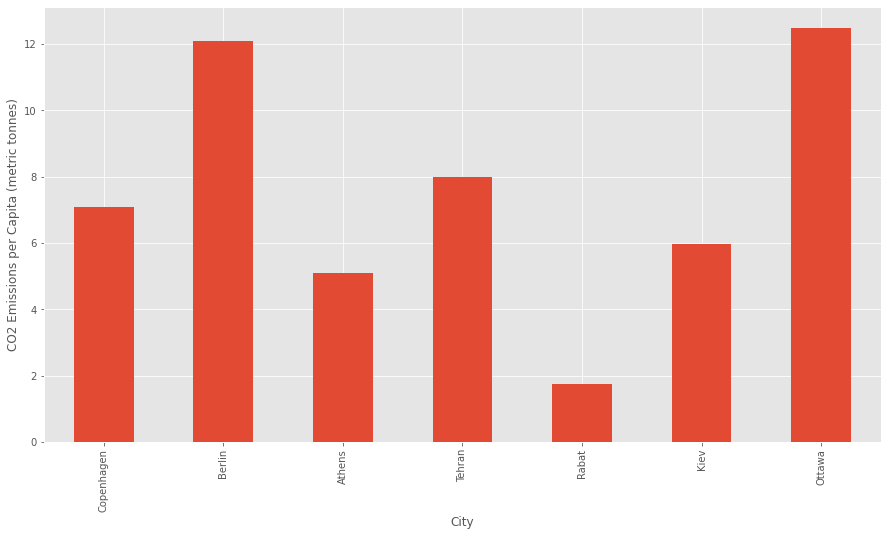

In [33]:
dff['CO2 Emissions per Capita (metric tonnes)'].plot(kind="bar")
plt.ylabel('CO2 Emissions per Capita (metric tonnes)')

([<matplotlib.patches.Wedge at 0x277964dd880>,
 [Text(0.9910657451172095, 0.47727213291294374, 'BusTransit Sprawl'),
  Text(0.24477296280441296, 1.0724207181325571, 'Congested Emerging'),
  Text(-0.9910658121453628, 0.4772719937275313, 'Hybrid Giant'),
  Text(-0.6858386267552901, -0.8600147545539077, 'MassTransit Heavyweight'),
  Text(0.6858389890969951, -0.8600144655960223, 'MassTransit Moderate')])

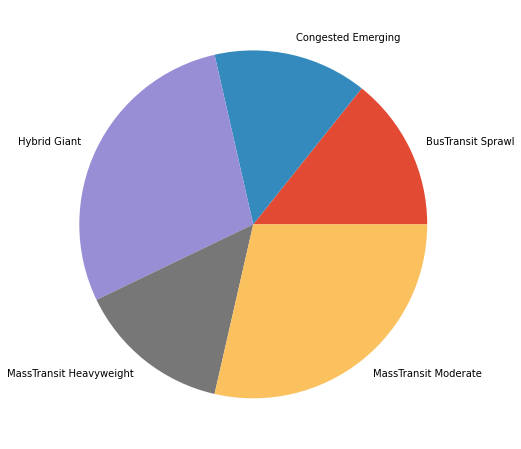

In [34]:
piechart = dff.groupby(['Typology'])['Typology'].count()
plt.pie(piechart, labels=piechart.index)

As before, there are no patterns or similarities to be found with these neighbors.

In conclusion, we did not any links between economic nor density factors and the spread of Covid-19.
This might tell us that the infection rates could be more related to other attributes and decisions like how the authorities have set up to guide the country through the pandemic. Political factors might be be playing a significant role but that can not be tested with the data available in the cities dataset.